In [1]:
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from glob import glob
from scipy import interpolate
import warnings
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn.metrics import mean_squared_error 
from math import sqrt
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
warnings.filterwarnings("ignore")
sys.path.append(str(Path(os.getcwd())))

base_path = Path(os.getcwd()).parent.parent
sys.path.append(base_path)

water_lst = glob(f'{base_path}/datasource/competition_data/water_data/*.csv')
rain_lst = glob(f'{base_path}/datasource/competition_data/rf_data/*.csv')

water_df = pd.DataFrame()
rain_df = pd.DataFrame()
for w in water_lst:
    water_df = water_df.append(pd.read_csv(w))
for r in rain_lst:
    rain_df = rain_df.append(pd.read_csv(r))
    
plt.rc('font', family = 'Malgun Gothic')

# datetime
water_df['ymdhm'] = pd.to_datetime(water_df['ymdhm'], format = '%Y-%m-%d %H:%M:%S' )
rain_df['ymdhm'] = pd.to_datetime(rain_df['ymdhm'], format = '%Y-%m-%d %H:%M:%S' )

# merge to dataframe
merge_df = pd.merge(water_df, rain_df, how = 'left', on = 'ymdhm')

new_cols ={'ymdhm':"date",
           'swl':'팔당댐 현재수위',
           'inf':'팔당댐 유입량',
           'sfw':'팔당댐 저수량',
           'ecpc':'팔당댐 공용량',
           'tototf':'총 방류량',
           'tide_level':"강화대교 조위",
           'fw_1018662':'청담대교 유량',
           'fw_1018680':'잠수교 유량',
           'fw_1018683':'한강대교 유량',
           'fw_1019630':'행주대교 유량',
           'wl_1018662':'청담대교 수위',    
           'wl_1018680':'잠수교 수위',
           'wl_1018683':"한강대교 수위",
           'wl_1019630':"행주대교 수위",
           'rf_10184100':'대곡교 강수량',
           'rf_10184110':'진관교 강수량',
           'rf_10184140':'송정동 강수량'}
merge_df =merge_df.rename(columns = new_cols)

# test set: 2022 06 01 ~
train = merge_df[-((merge_df['date'].dt.year==2022) & (merge_df['date'].dt.month>=6))].reset_index(drop =True)
test = merge_df[((merge_df['date'].dt.year==2022) & (merge_df['date'].dt.month>=6))].reset_index(drop =True)

In [2]:
train

,date,팔당댐 현재수위,팔당댐 유입량,팔당댐 저수량,팔당댐 공용량,총 방류량,강화대교 조위,청담대교 수위,청담대교 유량,잠수교 수위,잠수교 유량,한강대교 수위,한강대교 유량,행주대교 수위,행주대교 유량,대곡교 강수량,진관교 강수량,송정동 강수량
0,2012-05-01 00:00:00,24.800,555.00,219.07,24.93,555.00,445.0,310.7,469.05,300.2,0.0,290.0,729.80,275.3,540.18,0.0,0.0,0.0
1,2012-05-01 00:10:00,24.794,464.60,218.86,25.15,562.90,449.0,314.7,498.00,300.2,0.0,290.0,731.48,275.3,540.18,0.0,0.0,0.0
2,2012-05-01 00:20:00,24.789,478.10,218.69,25.31,576.40,451.0,313.7,490.68,301.2,0.0,290.0,726.42,275.3,540.18,0.0,0.0,0.0
3,2012-05-01 00:30:00,24.789,464.80,218.69,25.31,563.10,452.0,311.7,476.21,301.2,0.0,290.0,726.42,276.3,552.17,0.0,0.0,0.0
4,2012-05-01 00:40:00,24.789,478.10,218.69,25.31,576.40,450.0,311.7,476.21,301.2,0.0,291.0,707.17,277.3,564.29,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269419,2022-05-31 23:10:00,25.180,140.94,217.99,26.01,140.94,220.0,281.7,285.72,281.2,NaN,278.0,575.57,271.3,493.58,0.0,0.0,0.0
269420,2022-05-31 23:20:00,25.180,141.07,217.99,26.01,141.07,208.0,279.7,274.78,279.2,NaN,278.0,501.04,272.3,505.03,0.0,0.0,0.0
269421,2022-05-31 23:30:00,25.180,141.01,217.99,26.01,141.01,196.0,278.7,269.40,277.2,NaN,277.0,425.89,272.3,505.03,0.0,0.0,0.0
269422,2022-05-31 23:40:00,25.190,755.75,218.36,25.64,140.75,184.0,277.7,264.07,276.2,NaN,276.0,198.19,271.3,493.58,0.0,0.0,0.0


In [3]:
train.isna().sum()

date             0
팔당댐 현재수위       707
팔당댐 유입량        707
팔당댐 저수량        707
팔당댐 공용량        707
총 방류량          707
강화대교 조위       4923
청담대교 수위         59
청담대교 유량      15164
잠수교 수위          59
잠수교 유량      189937
한강대교 수위         59
한강대교 유량       1279
행주대교 수위         59
행주대교 유량         59
대곡교 강수량          0
진관교 강수량          0
송정동 강수량          0
dtype: int64

잠수교 유량은 원래 nan값

팔당댐과 가까운 대교 일수록 표고가 높다.

In [4]:
sample = train[train['date'].dt.year ==2020]
sample

,date,팔당댐 현재수위,팔당댐 유입량,팔당댐 저수량,팔당댐 공용량,총 방류량,강화대교 조위,청담대교 수위,청담대교 유량,잠수교 수위,잠수교 유량,한강대교 수위,한강대교 유량,행주대교 수위,행주대교 유량,대곡교 강수량,진관교 강수량,송정동 강수량
211968,2020-05-01 00:00:00,25.02,34.0,212.14,31.86,135.0,398.0,278.7,269.40,279.2,NaN,264.0,231.30,252.3,301.39,0.0,0.0,0.0
211969,2020-05-01 00:10:00,25.01,0.0,211.77,32.23,135.0,386.0,278.7,269.40,279.2,NaN,264.0,219.12,252.3,301.39,0.0,0.0,0.0
211970,2020-05-01 00:20:00,25.01,0.0,211.77,32.23,135.0,374.0,278.7,269.40,279.2,NaN,264.0,215.07,252.3,301.39,0.0,0.0,0.0
211971,2020-05-01 00:30:00,25.01,0.0,211.77,32.23,135.0,363.0,278.7,269.40,279.2,NaN,264.0,219.12,251.3,292.61,0.0,0.0,0.0
211972,2020-05-01 00:40:00,25.01,28.0,211.77,32.23,129.0,352.0,278.7,269.40,279.2,NaN,264.0,227.24,250.3,283.96,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238459,2020-10-31 23:10:00,25.12,136.0,215.79,28.21,136.0,234.0,324.7,574.28,340.2,NaN,324.0,295.70,316.3,1142.22,0.0,0.0,0.0
238460,2020-10-31 23:20:00,25.11,34.0,215.42,28.58,136.0,223.0,325.7,582.21,339.2,NaN,322.0,189.27,314.3,1107.57,0.0,0.0,0.0
238461,2020-10-31 23:30:00,25.09,0.0,214.69,29.31,137.0,211.0,326.7,590.20,338.2,NaN,321.0,215.39,310.3,1039.90,0.0,0.0,0.0
238462,2020-10-31 23:40:00,25.09,0.0,214.69,29.31,137.0,200.0,327.7,598.25,338.2,NaN,320.0,228.26,307.3,990.57,0.0,0.0,0.0


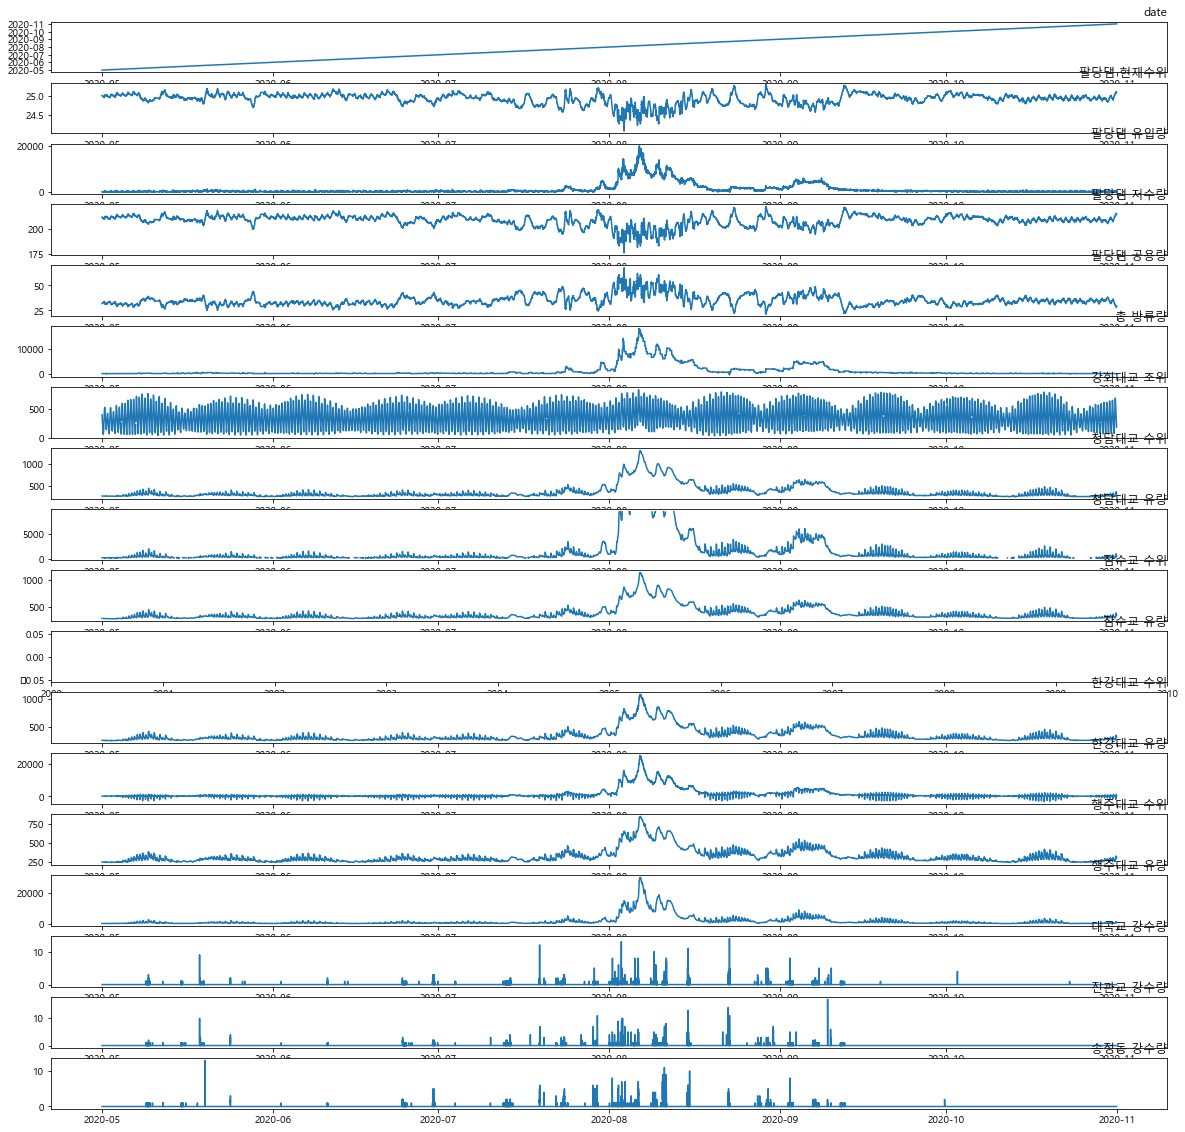

In [5]:
sample = train[train['date'].dt.year ==2020]
# VIZ
count_cols = len(list(sample.columns))
fig,ax = plt.subplots(count_cols,1,figsize = (20,20))
for i,c in enumerate(list(sample.columns)):
    ax[i].plot(sample['date'],sample[c])
    ax[i].set_title(f'{c}',loc = 'right')
plt.show()

- 저수량과 공용량은 음의 상관관계가 매우 높다.
- 수위는 8월에 평균적으로 낮으며, 최저점을 기록한다.
- 유입랑과, 공용량, 방류량은 8월에 가장 많으며 강수량또한 이시기에 월평균 가장 많다.
- 강화대교 조위는 계절성을 보인다.
- 각 대교의 해발표고 역시 8월이 가장높다.

<AxesSubplot:xlabel='date', ylabel='청담대교 수위'>

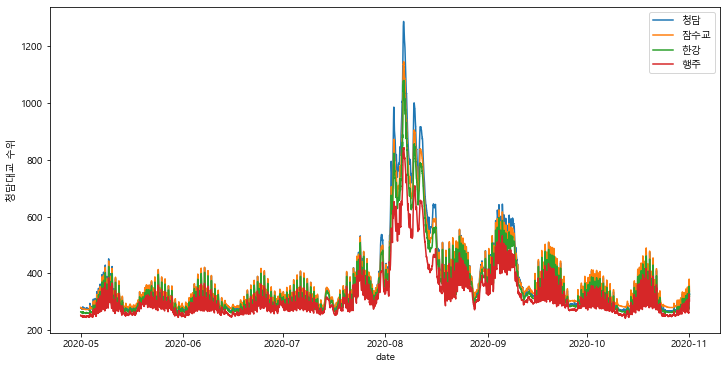

In [6]:
plt.figure(figsize = (12,6))
# sns.lineplot(train_df['date'],train_df['총 방류량'])
sns.lineplot(sample['date'], sample['청담대교 수위'],label = '청담')
sns.lineplot(sample['date'], sample['잠수교 수위'],label = '잠수교')
sns.lineplot(sample['date'], sample['한강대교 수위'],label = '한강')
sns.lineplot(sample['date'], sample['행주대교 수위'],label = '행주')

<AxesSubplot:xlabel='date', ylabel='팔당댐 유입량'>

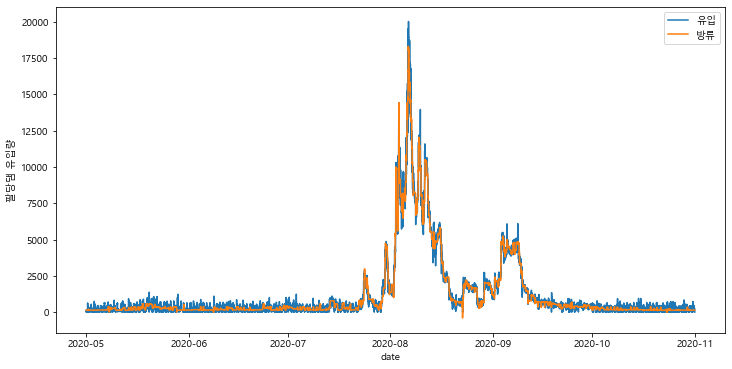

In [8]:
plt.figure(figsize = (12,6))
sns.lineplot(sample['date'], sample['팔당댐 유입량'],label = '유입')
sns.lineplot(sample['date'], sample['총 방류량'],label = '방류')

<AxesSubplot:xlabel='date', ylabel='강화대교 조위'>

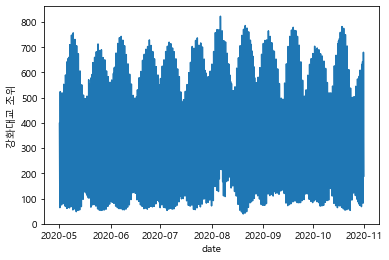

In [9]:
sns.lineplot(sample['date'], sample['강화대교 조위'])

조석에 의한 시계열 특성을 가지는것 같다.

In [10]:
shift_df = sample[['date','총 방류량','청담대교 수위','잠수교 수위','한강대교 수위', '행주대교 수위']]

In [11]:
shift_df[shift_df['date'].dt.month==8].head(60)

,date,총 방류량,청담대교 수위,잠수교 수위,한강대교 수위,행주대교 수위
225216,2020-08-01 00:00:00,1368.0,368.7,367.2,354.0,328.3
225217,2020-08-01 00:10:00,1368.0,369.7,367.2,354.0,328.3
225218,2020-08-01 00:20:00,1368.0,368.7,367.2,354.0,328.3
225219,2020-08-01 00:30:00,1369.0,369.7,367.2,354.0,327.3
225220,2020-08-01 00:40:00,1369.0,369.7,367.2,354.0,328.3
225221,2020-08-01 00:50:00,1369.0,368.7,367.2,354.0,328.3
225222,2020-08-01 01:00:00,1369.0,368.7,367.2,354.0,328.3
225223,2020-08-01 01:10:00,1369.0,369.7,367.2,354.0,328.3
225224,2020-08-01 01:20:00,1369.0,368.7,367.2,354.0,328.3
225225,2020-08-01 01:30:00,1369.0,367.7,367.2,353.0,328.3


<AxesSubplot:xlabel='date', ylabel='총 방류량'>

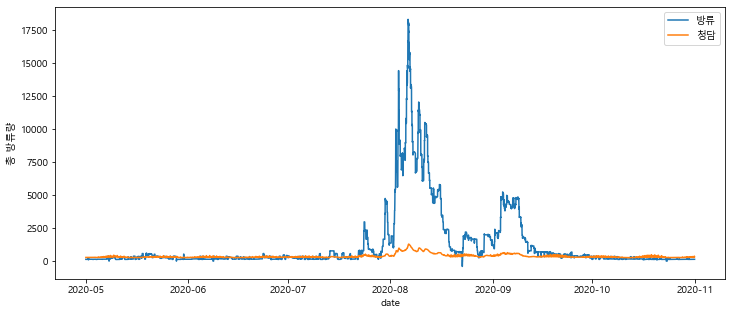

In [12]:
plt.figure(figsize = (12,5))
sns.lineplot(shift_df['date'],shift_df['총 방류량'],label ='방류')
sns.lineplot(shift_df['date'],shift_df['청담대교 수위'],label ='청담')

<AxesSubplot:xlabel='date', ylabel='총 방류량'>

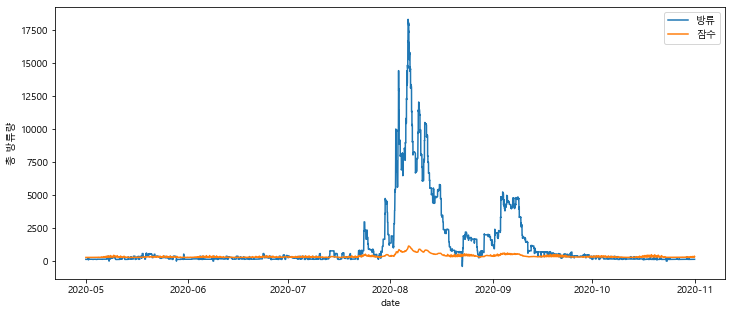

In [13]:
plt.figure(figsize = (12,5))
sns.lineplot(shift_df['date'],shift_df['총 방류량'],label ='방류')
sns.lineplot(shift_df['date'],shift_df['잠수교 수위'],label ='잠수')

<AxesSubplot:xlabel='date', ylabel='총 방류량'>

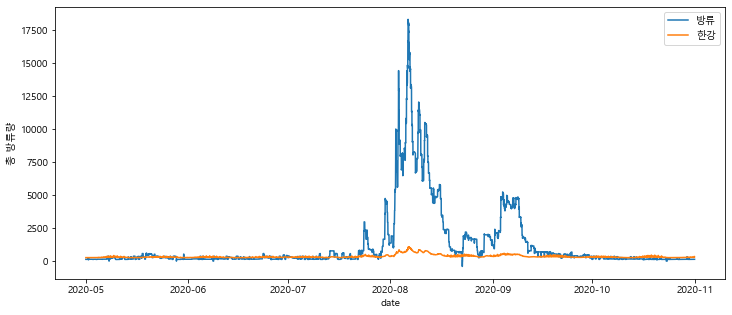

In [14]:
plt.figure(figsize = (12,5))
sns.lineplot(shift_df['date'],shift_df['총 방류량'],label ='방류')
sns.lineplot(shift_df['date'],shift_df['한강대교 수위'],label ='한강')

<AxesSubplot:xlabel='date', ylabel='총 방류량'>

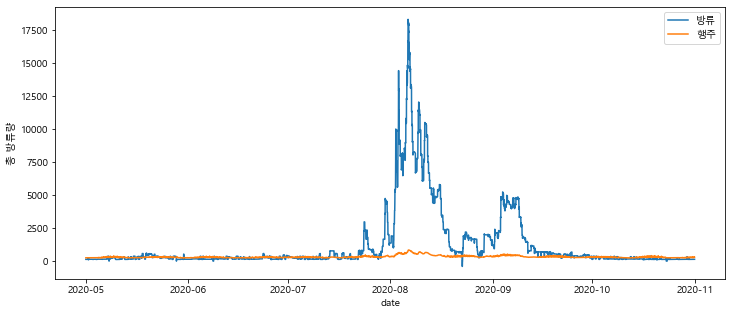

In [15]:
plt.figure(figsize = (12,5))
sns.lineplot(shift_df['date'],shift_df['총 방류량'],label ='방류')
sns.lineplot(shift_df['date'],shift_df['행주대교 수위'],label ='행주')

<AxesSubplot:xlabel='date', ylabel='잠수교 수위'>

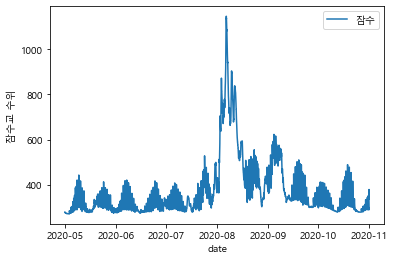

In [16]:
sns.lineplot(sample['date'], sample['잠수교 수위'],label = '잠수')

<AxesSubplot:xlabel='date', ylabel='청담대교 수위'>

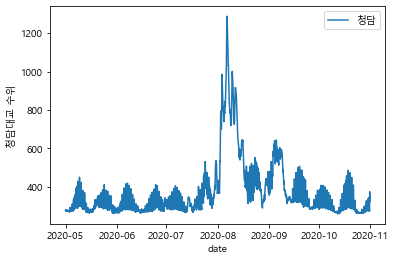

In [17]:
sns.lineplot(sample['date'], sample['청담대교 수위'],label = '청담')

왜 월별로 중간에 수위가 높아지는 계절성느낌의 형태가 보이는걸까?

In [18]:
sample[sample['date'].dt.month == 5][['date','잠수교 수위']]

,date,잠수교 수위
211968,2020-05-01 00:00:00,279.2
211969,2020-05-01 00:10:00,279.2
211970,2020-05-01 00:20:00,279.2
211971,2020-05-01 00:30:00,279.2
211972,2020-05-01 00:40:00,279.2
...,...,...
216427,2020-05-31 23:10:00,281.2
216428,2020-05-31 23:20:00,280.2
216429,2020-05-31 23:30:00,280.2
216430,2020-05-31 23:40:00,280.2


<AxesSubplot:xlabel='date', ylabel='잠수교 수위'>

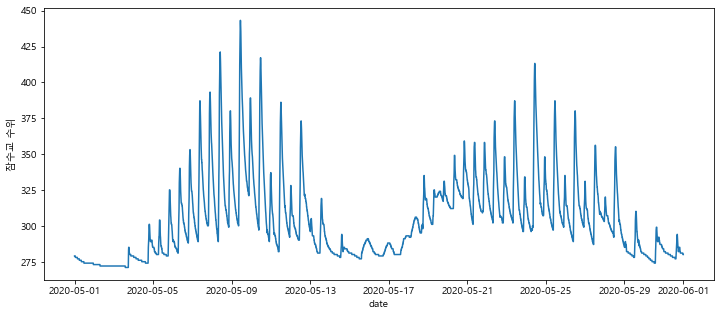

In [19]:
plt.figure(figsize = (12,5))
sns.lineplot(sample[sample['date'].dt.month == 5]['date'],sample[sample['date'].dt.month == 5]['잠수교 수위'])

<AxesSubplot:xlabel='date', ylabel='잠수교 수위'>

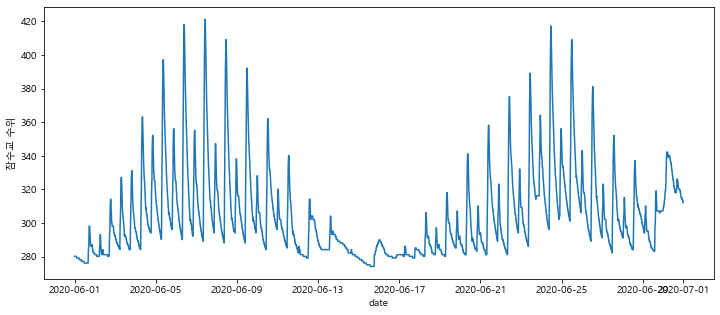

In [20]:
plt.figure(figsize = (12,5))
sns.lineplot(sample[sample['date'].dt.month == 6]['date'],sample[sample['date'].dt.month == 6]['잠수교 수위'])

<AxesSubplot:xlabel='date', ylabel='잠수교 수위'>

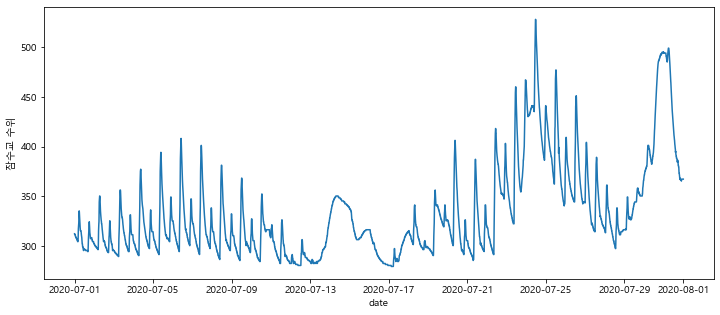

In [21]:
plt.figure(figsize = (12,5))
sns.lineplot(sample[sample['date'].dt.month == 7]['date'],sample[sample['date'].dt.month == 7]['잠수교 수위'])

<AxesSubplot:xlabel='date', ylabel='잠수교 수위'>

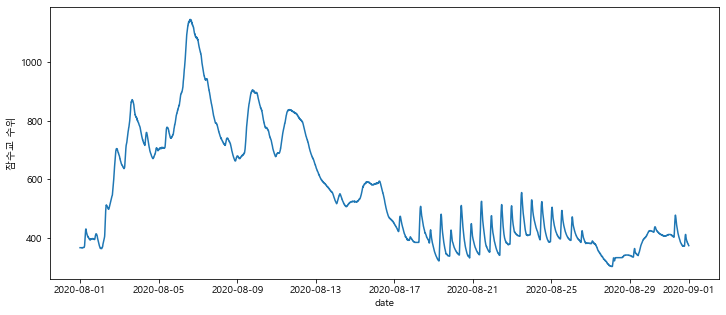

In [22]:
plt.figure(figsize = (12,5))
sns.lineplot(sample[sample['date'].dt.month == 8]['date'],sample[sample['date'].dt.month == 8]['잠수교 수위'])

<AxesSubplot:xlabel='date', ylabel='잠수교 수위'>

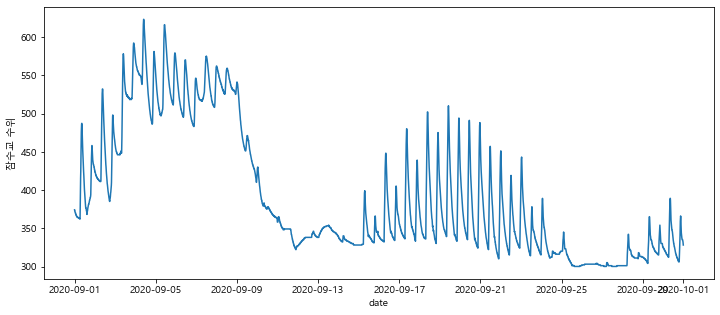

In [23]:
plt.figure(figsize = (12,5))
sns.lineplot(sample[sample['date'].dt.month == 9]['date'],sample[sample['date'].dt.month == 9]['잠수교 수위'])

<AxesSubplot:xlabel='date', ylabel='총 방류량'>

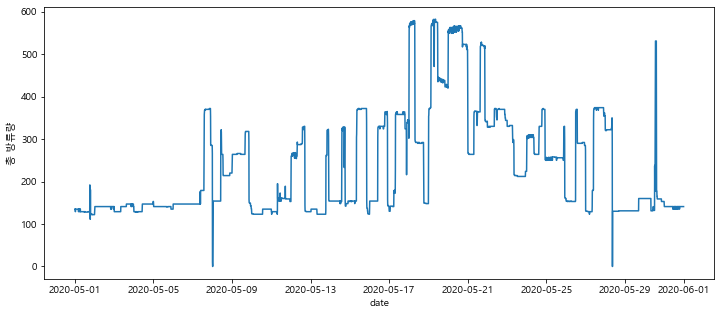

In [24]:
plt.figure(figsize = (12,5))
sns.lineplot(sample[sample['date'].dt.month == 5]['date'],sample[sample['date'].dt.month == 5]['총 방류량'])

<AxesSubplot:xlabel='date', ylabel='총 방류량'>

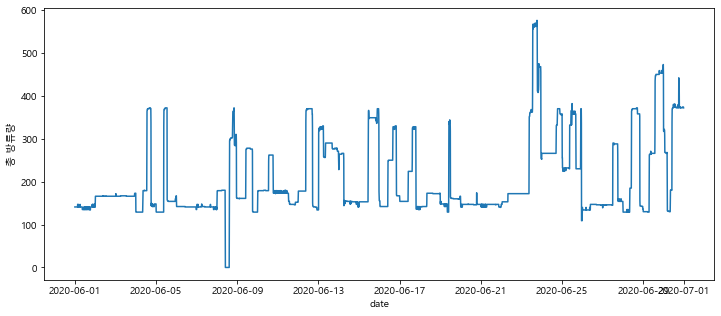

In [25]:
plt.figure(figsize = (12,5))
sns.lineplot(sample[sample['date'].dt.month == 6]['date'],sample[sample['date'].dt.month == 6]['총 방류량'])

<AxesSubplot:xlabel='date', ylabel='총 방류량'>

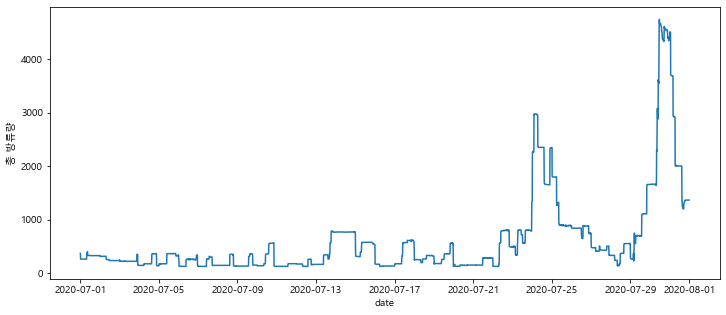

In [26]:
plt.figure(figsize = (12,5))
sns.lineplot(sample[sample['date'].dt.month == 7]['date'],sample[sample['date'].dt.month == 7]['총 방류량'])

규칙성은 없어보인다.

# Correlation for lag

In [106]:
df_2012 = train[train['date'].dt.year ==2012]

In [107]:
date_series = df_2012['date']

In [108]:
df_2012 = df_2012[['팔당댐 현재수위', '팔당댐 유입량', '팔당댐 저수량', '팔당댐 공용량', '총 방류량','청담대교 수위', '잠수교 수위', '한강대교 수위', '행주대교 수위']].reset_index(drop = True)

In [109]:
df_2012

,팔당댐 현재수위,팔당댐 유입량,팔당댐 저수량,팔당댐 공용량,총 방류량,청담대교 수위,잠수교 수위,한강대교 수위,행주대교 수위
0,24.800,555.0,219.07,24.93,555.0,310.7,300.2,290.0,275.3
1,24.794,464.6,218.86,25.15,562.9,314.7,300.2,290.0,275.3
2,24.789,478.1,218.69,25.31,576.4,313.7,301.2,290.0,275.3
3,24.789,464.8,218.69,25.31,563.1,311.7,301.2,290.0,276.3
4,24.789,478.1,218.69,25.31,576.4,311.7,301.2,291.0,277.3
...,...,...,...,...,...,...,...,...,...
26491,25.250,270.2,235.01,8.99,270.2,372.7,364.2,365.0,351.3
26492,25.250,264.1,235.01,8.99,264.1,365.7,359.2,362.0,350.3
26493,25.250,257.9,235.01,8.99,257.9,362.7,356.2,359.0,349.3
26494,25.250,264.1,235.01,8.99,264.1,355.7,352.2,356.0,346.3


In [110]:
df_2012.head(11)

,팔당댐 현재수위,팔당댐 유입량,팔당댐 저수량,팔당댐 공용량,총 방류량,청담대교 수위,잠수교 수위,한강대교 수위,행주대교 수위
0,24.800,555.0,219.07,24.93,555.0,310.7,300.2,290.0,275.3
1,24.794,464.6,218.86,25.15,562.9,314.7,300.2,290.0,275.3
2,24.789,478.1,218.69,25.31,576.4,313.7,301.2,290.0,275.3
3,24.789,464.8,218.69,25.31,563.1,311.7,301.2,290.0,276.3
4,24.789,478.1,218.69,25.31,576.4,311.7,301.2,291.0,277.3
5,24.789,478.1,218.69,25.31,576.4,311.7,301.2,291.0,277.3
6,24.790,464.0,218.73,25.27,562.0,312.7,301.2,291.0,277.3
7,24.789,563.1,218.69,25.31,563.1,311.7,301.2,291.0,277.3
8,24.789,576.4,218.69,25.31,576.4,312.7,301.2,291.0,278.3
9,24.789,576.4,218.69,25.31,576.4,312.7,301.2,291.0,278.3


In [111]:
# 1 ~ 6h lag
basic_shift = 6
damCols = ['팔당댐 현재수위', '팔당댐 유입량', '팔당댐 저수량', '팔당댐 공용량', '총 방류량']
for j in damCols:
    for i in range(0,len(damCols)):
        df_2012[f"{j}_step{i+1}"] = df_2012[j].shift((i+1)*basic_shift)

In [112]:
df_2012.columns

Index(['팔당댐 현재수위', '팔당댐 유입량', '팔당댐 저수량', '팔당댐 공용량', '총 방류량', '청담대교 수위',
       '잠수교 수위', '한강대교 수위', '행주대교 수위', '팔당댐 현재수위_step1', '팔당댐 현재수위_step2',
       '팔당댐 현재수위_step3', '팔당댐 현재수위_step4', '팔당댐 현재수위_step5', '팔당댐 유입량_step1',
       '팔당댐 유입량_step2', '팔당댐 유입량_step3', '팔당댐 유입량_step4', '팔당댐 유입량_step5',
       '팔당댐 저수량_step1', '팔당댐 저수량_step2', '팔당댐 저수량_step3', '팔당댐 저수량_step4',
       '팔당댐 저수량_step5', '팔당댐 공용량_step1', '팔당댐 공용량_step2', '팔당댐 공용량_step3',
       '팔당댐 공용량_step4', '팔당댐 공용량_step5', '총 방류량_step1', '총 방류량_step2',
       '총 방류량_step3', '총 방류량_step4', '총 방류량_step5'],
      dtype='object')

In [113]:
df_2012 = pd.concat([pd.DataFrame(date_series), df_2012],axis = 1)
df_2012

,date,팔당댐 현재수위,팔당댐 유입량,팔당댐 저수량,팔당댐 공용량,총 방류량,청담대교 수위,잠수교 수위,한강대교 수위,행주대교 수위,...,팔당댐 공용량_step1,팔당댐 공용량_step2,팔당댐 공용량_step3,팔당댐 공용량_step4,팔당댐 공용량_step5,총 방류량_step1,총 방류량_step2,총 방류량_step3,총 방류량_step4,총 방류량_step5
0,2012-05-01 00:00:00,24.800,555.0,219.07,24.93,555.0,310.7,300.2,290.0,275.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-05-01 00:10:00,24.794,464.6,218.86,25.15,562.9,314.7,300.2,290.0,275.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2012-05-01 00:20:00,24.789,478.1,218.69,25.31,576.4,313.7,301.2,290.0,275.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2012-05-01 00:30:00,24.789,464.8,218.69,25.31,563.1,311.7,301.2,290.0,276.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012-05-01 00:40:00,24.789,478.1,218.69,25.31,576.4,311.7,301.2,291.0,277.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26491,2012-10-31 23:10:00,25.250,270.2,235.01,8.99,270.2,372.7,364.2,365.0,351.3,...,9.71,10.42,10.42,10.34,10.78,270.5,264.9,272.1,375.9,541.4
26492,2012-10-31 23:20:00,25.250,264.1,235.01,8.99,264.1,365.7,359.2,362.0,350.3,...,9.71,10.29,10.26,10.24,10.67,270.5,264.7,265.5,263.8,536.0
26493,2012-10-31 23:30:00,25.250,257.9,235.01,8.99,257.9,362.7,356.2,359.0,349.3,...,9.71,10.09,10.63,10.42,10.81,270.5,258.5,265.5,274.0,537.1
26494,2012-10-31 23:40:00,25.250,264.1,235.01,8.99,264.1,355.7,352.2,356.0,346.3,...,9.71,10.09,10.43,10.41,10.81,258.2,258.3,265.1,267.6,537.7


In [114]:
df_2012 = df_2012.dropna()
df_2012

,date,팔당댐 현재수위,팔당댐 유입량,팔당댐 저수량,팔당댐 공용량,총 방류량,청담대교 수위,잠수교 수위,한강대교 수위,행주대교 수위,...,팔당댐 공용량_step1,팔당댐 공용량_step2,팔당댐 공용량_step3,팔당댐 공용량_step4,팔당댐 공용량_step5,총 방류량_step1,총 방류량_step2,총 방류량_step3,총 방류량_step4,총 방류량_step5
30,2012-05-01 05:00:00,24.790,564.0,218.73,25.27,564.0,313.7,302.2,292.0,278.3,...,25.27,25.27,25.27,25.27,24.93,558.0,570.0,564.0,562.0,555.0
31,2012-05-01 05:10:00,24.789,576.8,218.69,25.31,576.8,313.7,302.2,292.0,278.3,...,25.31,25.31,25.31,25.31,25.15,576.8,576.8,576.8,563.1,562.9
32,2012-05-01 05:20:00,24.789,576.8,218.69,25.31,576.8,313.7,302.2,292.0,278.3,...,25.31,25.31,25.31,25.31,25.31,576.8,563.4,576.8,576.4,576.4
33,2012-05-01 05:30:00,24.789,576.8,218.69,25.31,576.8,313.7,302.2,292.0,278.3,...,25.31,25.31,25.31,25.31,25.31,576.8,576.8,576.8,576.4,563.1
34,2012-05-01 05:40:00,24.789,576.8,218.69,25.31,576.8,313.7,302.2,292.0,278.3,...,25.31,25.31,25.31,25.31,25.31,576.8,576.8,576.8,576.8,576.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26491,2012-10-31 23:10:00,25.250,270.2,235.01,8.99,270.2,372.7,364.2,365.0,351.3,...,9.71,10.42,10.42,10.34,10.78,270.5,264.9,272.1,375.9,541.4
26492,2012-10-31 23:20:00,25.250,264.1,235.01,8.99,264.1,365.7,359.2,362.0,350.3,...,9.71,10.29,10.26,10.24,10.67,270.5,264.7,265.5,263.8,536.0
26493,2012-10-31 23:30:00,25.250,257.9,235.01,8.99,257.9,362.7,356.2,359.0,349.3,...,9.71,10.09,10.63,10.42,10.81,270.5,258.5,265.5,274.0,537.1
26494,2012-10-31 23:40:00,25.250,264.1,235.01,8.99,264.1,355.7,352.2,356.0,346.3,...,9.71,10.09,10.43,10.41,10.81,258.2,258.3,265.1,267.6,537.7


In [115]:
df_2012 = df_2012.reset_index(drop = True)

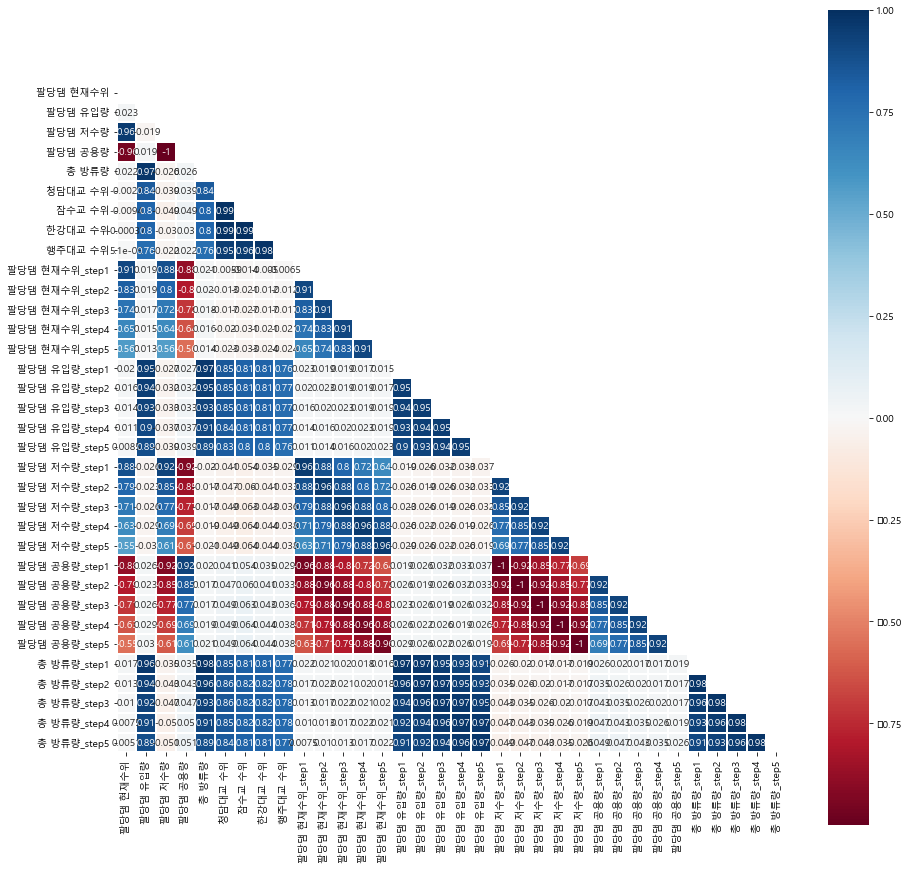

In [117]:
plt.rc('font', family = 'Malgun Gothic')
plt.figure(figsize = (15,15))

mask = np.zeros_like(df_2012.corr())
mask[np.triu_indices_from(mask)] = True
colormap = plt.cm.RdBu

result = sns.heatmap(df_2012.corr(), mask = mask, linewidths=0.1,vmax=1.0, 
            square=True,cmap = colormap,   linecolor='white', annot=True)